In [ ]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Citzen Science Notebook</b> <br>
Contact author: Sreevani Jarugula and Becky Nevin<br>
Last verified to run: 2023-04-20 <br>
LSST Science Pipelines version: Weekly 2023_xx <br>
Container size: medium <br>


**Description:**
Query and send variable star images and light curves from RSP to Zooniverse

**Skills:** Use various TAP tables, including joining multiple tables. Get calexp images. Extract time-series photometry.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.MatchesTruth, TruthSummary, ForcedSource, CcdVisit<br>

**Packages:** astropy, lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, lsst.daf.butler, lsst.afw.display, lsst.geom 

**Credit:** Tutorial notebooks 03a, 04a, 04b, 07b, and 08

**Support:** Support is available and questions are welcome - (some email/link etc)

DEBUG VERSION note that this version of the notebook contains additional debugging and the first cell will need to be run once

## 1. Introduction <a class="anchor" id="first-bullet"></a>
This notebook will guide you through the process of sending variable star data from the Rubin Science Platform (RSP) to the Zooniverse.

This notebook will restrict the number of object sent to the Zooniverse to one variable star over five exposures. This limit is intended to demonstrate your project prior to full approval from the education and public outreach (EPO) Data Rights Panel.

### 1.1 Package imports <a class="anchor" id="second-bullet"></a>

#### Install Pipeline Package

First, install the Rubin Citizen Science Pipeline package by doing the following:

1. Open up a New Launcher tab
2. In the "Other" section of the New Launcher tab, click "Terminal"
3. Use `pip` to install the `rubin.citsci` package by entering the following command:
```
pip install rubin.citsci
```
4. Confirm the next cell containing `from rubin.citsci import pipeline` works as expected and does not throw an error

!pip install --upgrade --force-reinstall --no-deps rubin.citsci --quiet

In [17]:
import utils
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import gc
import numpy as np
import pandas
import pandas as pd
import time
import os
import astropy
import matplotlib

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.coordinates import SkyCoord

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler provides programmatic access to LSST data products.
from lsst.daf.butler import Butler
# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

# Must explicitly set this to save figures
afwDisplay.setDefaultBackend("matplotlib")


### 1.2 Define functions and parameters <a class="anchor" id="third-bullet"></a>
If you haven't already, [create a Zooniverse account](https://www.zooniverse.org/accounts/registerhttps://www.zooniverse.org/accounts/register) and create your project.

IMPORTANT: Your Zooniverse project must be set to "public", a "private" project will not work. Select this setting under the "Visibility" tab, (it does not need to be set to live). 


A "slug" is the string of your Zooniverse username and your project name without the leading forward slash, for instance: "username/project-name". [Click here for more details](https://www.zooniverse.org/talk/18/967061?comment=1898157&page=1).


In [2]:
# %load_ext pycodestyle_magic
# %flake8_on
# import logging
# logging.getLogger("flake8").setLevel(logging.FATAL)
email = "beckynevin@gmail.com"  
# slug_name = "sreevani/test-pcw23" 
slug_name = "rebecca-dot-nevin/test-project" 

from rubin.citsci import pipeline
print("Loading and running utilities to establish a link with Zooniverse")
print("Enter your Zooniverse username followed by password below")
cit_sci_pipeline = pipeline.CitSciPipeline()
cit_sci_pipeline.login_to_zooniverse(slug_name, email)

Loading and running utilities to establish a link with Zooniverse
Enter your Zooniverse username followed by password below
Enter your Zooniverse credentials...


Username:  rebecca.nevin
 ········


You now are logged in to the Zooniverse platform.


## 2. Make a subject set of variable stars to send to Zooniverse <a class="anchor" id="fourth-bullet"></a>
A subject set is a collection of data (images, plots, etc) that are shown to citizen scientists. It is also the unit of data that is sent to Zooniverse.

Here, we curate the subject set of objects to send to Zooniverse. This can be modified to create your own subject set. Your subject set must have 100 objects or less in the testing phase before your project is approved by the EPO Data Rights panel. 

This example makes two sets of image cutouts of two different variable stars at different moments in time.

### 2.1 Initialize TAP and Butler

In [3]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
service, butler, skymap = utils.setup_butler(config, collection)

## 2.2 Do a search for variable stars
For more details, please see the `DP02_07b_Variable_Star_Lightcurves.ipynb` notebook in the tutorial notebooks by Jeff Carlin and Ryan Lau. All the code in this section is taken directly from that notebook.

In [4]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

In [5]:
query = "SELECT diao.diaObjectId, fsodo.forcedSourceOnDiaObjectId, diao.ra, diao.decl, diao.nDiaSources, "\
        "diao.gPSFluxMin, diao.gPSFluxMax, diao.gPSFluxMean, diao.gPSFluxSigma, "\
        "diao.gPSFluxMAD, diao.gPSFluxChi2, diao.gPSFluxNdata, diao.gPSFluxSkew, "\
        "diao.gPSFluxStetsonJ, diao.gPSFluxPercentile05, diao.gPSFluxPercentile25, "\
        "diao.gPSFluxPercentile50, diao.gPSFluxPercentile75, diao.gPSFluxPercentile95, "\
        "diao.gTOTFluxMean, diao.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as psfMag, "\
        "scisql_nanojanskyToAbMag(diao.gTOTFluxMean) as diao_gmag, "\
        "fsodo.diaObjectId, "\
        "fsodo.ccdVisitId, fsodo.band, fsodo.psfFlux, fsodo.psfFluxErr, "\
        "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
        "cv.expMidptMJD, cv.detector, cv.visitId, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as fsodo_gmag "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
        "WHERE diao.gTOTFluxSigma/diao.gTOTFluxMean > 0.25 "\
        "AND diao.gTOTFluxSigma/diao.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.gTOTFluxMean) < 23 "\
        "AND diao.gPSFluxNdata > 30 "\
        "AND diao.gPSFluxStetsonJ > 20 "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5)) = 1 "

results = service.search(query)
fsodo_sources = results.to_table()
#        "AND fsodo.band = 'r' "\

In [6]:
# this returns a massive list of sources, some of which are repeat object IDs
fsodo_sources 

diaObjectId,forcedSourceOnDiaObjectId,ra,decl,nDiaSources,gPSFluxMin,gPSFluxMax,gPSFluxMean,gPSFluxSigma,gPSFluxMAD,gPSFluxChi2,gPSFluxNdata,gPSFluxSkew,gPSFluxStetsonJ,gPSFluxPercentile05,gPSFluxPercentile25,gPSFluxPercentile50,gPSFluxPercentile75,gPSFluxPercentile95,gTOTFluxMean,gTOTFluxSigma,psfMag,diao_gmag,diaObjectId2,ccdVisitId,band,psfFlux,psfFluxErr,psfDiffFlux,psfDiffFluxErr,expMidptMJD,detector,visitId,fsodo_gmag
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,nJy,nJy,nJy,nJy,d,,,
int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,int64,int64,float64
1568950316278219135,355690962002903599,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,17.864033402419253,19.144089969240454,1568950316278219135,662526045,g,259648.9908643,423.7730634,-219051.1495052,432.8655653,60560.2826042,45,662526,17.864033402419253
1568950316278219135,103713865241461849,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,19.063114664924566,19.144089969240454,1568950316278219135,193182128,r,86050.645805,298.5169185,-14602.9136397,303.6819171,59839.3507772,128,193182,19.063114664924566
1568950316278219135,226363652880469256,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,18.678994269516238,19.144089969240454,1568950316278219135,421635160,i,122575.1101511,390.8119071,5140.6030076,404.1377577,60180.3021012,160,421635,18.678994269516238
1568950316278219135,146708080233548429,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,18.29759788250864,19.144089969240454,1568950316278219135,273265094,z,174164.9851142,629.2273185,-19325.1093435,656.5473992,59963.0594742,94,273265,18.29759788250864
1568950316278219135,372739324120141658,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,19.51963739298456,19.144089969240454,1568950316278219135,694281094,r,56512.5680246,264.42331,-21719.446721,299.0289831,60605.3311952,94,694281,19.51963739298456
1568950316278219135,506936602707100152,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,19.066762363258093,19.144089969240454,1568950316278219135,944243004,g,85762.0304762,248.0646447,-274851.3347688,291.5739513,60962.2864662,4,944243,19.066762363258093
1568950316278219135,488489257535537224,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,190479.3757978,40.0,4.3615829,43.70482,-280456.048519,-275697.3167805,-269229.942403,-256930.8216228,-235362.2534603,79866.3822305,30506.3324512,18.090302320392844,19.144089969240454,1568950316278219135,909882146,r,210804.1089703,421.7247573,49089.868058,424.0791348,60905.3538062,146,909882,18.090302320392844
1568950316278219135,623081735390757741,67.2951662,-38.4159654,60,-283246.6563582,-99737.739113,-262856.00994,29630.0976096,7448.5975542,1

In [7]:
# listing by unique source instead:
unique_variables = astropy.table.unique(fsodo_sources,keys = 'diaObjectId')['diaObjectId','ra','decl','expMidptMJD','band','ccdVisitId','visitId', 'detector']
unique_variables

diaObjectId,ra,decl,expMidptMJD,band,ccdVisitId,visitId,detector
,deg,deg,d,,,,
int64,float64,float64,float64,object,int64,int64,int64
1567428592185376787,59.4814837,-37.7323315,61254.3419842,y,1141195101,1141195,101
1567762843720221100,62.5202159,-37.8646632,60280.2057552,r,480303131,480303,131
1568246628836442456,62.5202159,-37.8646632,61017.0802592,g,975962163,975962,163
1568950316278219135,67.2951662,-38.4159654,60560.2826042,g,662526045,662526,45
1569082257673552562,67.0155078,-37.8278368,59914.1755432,r,242558012,242558,12
1569135034231685181,67.4679316,-37.6786425,60275.0778372,z,476393014,476393,14
1651510445384663056,62.6536501,-35.9700212,60185.3811712,z,426670023,426670,23
1651589610221862935,62.1479038,-35.7991348,60540.4073132,y,646739066,646739,66


In [8]:
# For this tutorial, we will select one such source but you can choose another
# note that many of these sources are not true variables
diaobjectID = 1567428592185376787
selection = unique_variables[unique_variables["diaObjectId"]==diaobjectID]
#selection = unique_variables
ra = selection['ra'].value[0]
dec = selection['decl'].value[0]
print('ra and dec of variable star', ra, dec)

ra and dec of variable star 59.4814837 -37.7323315


### Now go back to the original table to get all of the information you need to plot a series of images

In [9]:
source = fsodo_sources[fsodo_sources["diaObjectId"]==diaobjectID]['diaObjectId','ra','decl','ccdVisitId','visitId',
                                                         'band','psfFlux','psfFluxErr',
                                                         'expMidptMJD','detector','psfMag']
source

diaObjectId,ra,decl,ccdVisitId,visitId,band,psfFlux,psfFluxErr,expMidptMJD,detector,psfMag
,deg,deg,,,,nJy,nJy,d,,
int64,float64,float64,int64,int64,object,float64,float64,float64,int64,float64
1567428592185376787,59.4814837,-37.7323315,1141195101,1141195,y,217274.9132152,1755.4059358,61254.3419842,101,18.05747603718028
1567428592185376787,59.4814837,-37.7323315,1212153079,1212153,i,220985.9696981,590.3284039,61364.2925662,79,18.039088246512566
1567428592185376787,59.4814837,-37.7323315,662532066,662532,g,196440.0949505,433.4549124,60560.2854312,66,18.16692466155384
1567428592185376787,59.4814837,-37.7323315,909782131,909782,r,195614.2995458,482.6527048,60905.3085432,131,18.171498502873554
1567428592185376787,59.4814837,-37.7323315,1047475123,1047475,z,275528.8518518,935.3058406,61118.0144062,123,17.799582293809436
1567428592185376787,59.4814837,-37.7323315,904789050,904789,y,283345.1047675,1523.756618,60899.4044252,50,17.769210715195413
1567428592185376787,59.4814837,-37.7323315,676185120,676185,r,209555.5588523,490.1820967,60583.3096732,120,18.09675203551415
1567428592185376787,59.4814837,-37.7323315,266167081,266167,y,289677.4273541,1792.3334894,59950.1359082,81,17.74521336293549


## Is it possible to just use the info we already have to plot images?


In [10]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

pick = {}
for filter in plot_filter_labels:
    pick[filter] = (source['band'] == filter)

In [11]:
# also select some key moments in time
# begin by ordering by mjd
print(type(source[pick['r']]))
select_r = source[pick['r']]
sorted_sources = select_r[select_r['expMidptMJD'].argsort()]
sorted_sources



<class 'astropy.table.table.Table'>


diaObjectId,ra,decl,ccdVisitId,visitId,band,psfFlux,psfFluxErr,expMidptMJD,detector,psfMag
,deg,deg,,,,nJy,nJy,d,,
int64,float64,float64,int64,int64,object,float64,float64,float64,int64,float64
1567428592185376787,59.4814837,-37.7323315,40327030,40327,r,258575.9147688,535.0198784,59634.0870892,30,17.86852982557396
1567428592185376787,59.4814837,-37.7323315,193147032,193147,r,207715.9826285,497.251246,59839.3340712,32,18.10632521388235
1567428592185376787,59.4814837,-37.7323315,193148018,193148,r,208104.7777051,490.872577,59839.3345202,18,18.1042948726672
1567428592185376787,59.4814837,-37.7323315,193187002,193187,r,202320.5385648,491.5006487,59839.3530702,2,18.134900068992444
1567428592185376787,59.4814837,-37.7323315,193848097,193848,r,232671.7968929,499.4616498,59840.2471442,97,17.983140640366102
1567428592185376787,59.4814837,-37.7323315,202591070,202591,r,380253.6030788,636.4953924,59854.2787212,70,17.44981665528585
1567428592185376787,59.4814837,-37.7323315,202617009,202617,r,379673.378463,646.3810577,59854.2941412,9,17.451474632986304
1567428592185376787,59.4814837,-37.7323315,202618104,202618,r,379051.7059444,643.7650345,59854.2945992,104,17.45325386113064


In [12]:
idx_select = [10,15,25,40,63]

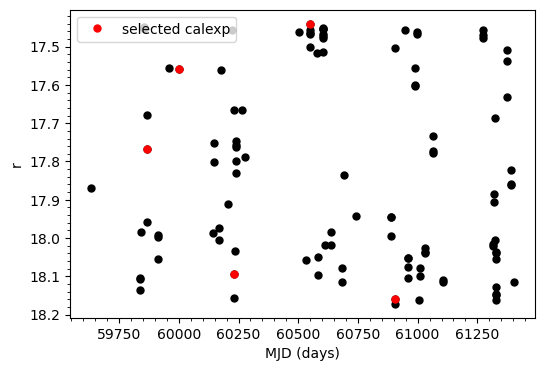

In [13]:
fig = plt.figure(figsize=(6, 4))
plt.plot(sorted_sources['expMidptMJD'], sorted_sources['psfMag'],
         'k.', ms=10)
plt.plot(sorted_sources[idx_select]['expMidptMJD'],
         sorted_sources[idx_select]['psfMag'],
         'r.', ms=10, label = 'selected calexp')
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.gca().invert_yaxis()
plt.legend(loc = 2)
plt.show()

## Now grab the calexp images from each of these moments

In [18]:
def get_cutout_image(butler, ra_deg, dec_deg, visit, detector, band, cutoutSideLength, datasetType='calexp'):
    """
    Get the cutout image information from butler. 
    This shoudl be followed by make_fig

    Input Parameters
    ----------
    ra : ra of source in degrees
    dec : dec of source in degrees
    visit : visit id
    detector : detector number
    band : band to get cutput for
    cutoutSideLength : size of the cutout
    
    Returns
    ----------
    Cutout image information
    """
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    
    radec = geom.SpherePoint(ra_deg,dec_deg, geom.degrees)
    
    dataId = {'visit': visit, 'detector': detector}  
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    
    print('calexp wcs: ', calexp_wcs)
    
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    print('xy: ',xy)
    print('bbox: ',bbox)
    
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)
    
    return cutout_image
def make_calexp_fig(cutout_image, ra, dec, out_name):
    """
    Create an image.
    should be followed with remove_figure
    
    Parameters
    ----------
    cutout_image : cutout_image from butler.get
    ra : ra of source in degrees
    dec : dec of source in degrees
    out_name : file name where you'd like to save it
    
    Returns
    ----------
    cutout image
    """
    # fig = plt.figure(figsize=(4, 4))
    # afw_display = afwDisplay.Display(frame=fig)
    # afw_display.scale('asinh', 'zscale')
    # afw_display.mtv(cutout_image.image)
    
#     cutout_wcs = cutout_image.getWcs()
#     radec = geom.SpherePoint(ra, dec, geom.degrees)
#     xy = geom.PointI(cutout_wcs.skyToPixel(radec))
    
#     afw_display.dot('x', xy.getX(), xy.getY(), size=1, ctype='orange')
#     plt.gca().axis('off')
#     plt.savefig(out_name)
    
    fig = plt.figure()
    plt.subplot(projection=WCS(cutout_image.getWcs().getFitsMetadata()))
    
    #print('wcs ra: ', cutout_image.getWcs().getFitsMetadata()['CRVAL1'])
    #print('wcs dec: ', cutout_image.getWcs().getFitsMetadata()['CRVAL2'])
    
    calexp_extent = (cutout_image.getBBox().beginX, cutout_image.getBBox().endX,
                 cutout_image.getBBox().beginY, cutout_image.getBBox().endY)
    im = plt.imshow(abs(cutout_image.image.array), cmap='gray', 
                extent=calexp_extent, origin='lower', norm = matplotlib.colors.LogNorm(vmin=1e1, vmax = 1e5))#, vmax=5e4))
    #im = plt.imshow(cutout_image.image.array, cmap='gray', vmin=-200.0, vmax=5000,
    #            extent=calexp_extent, origin='lower')
    plt.colorbar(location='right', anchor=(0, 0.1))
    # plt.gca().axis('off')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    plt.savefig(out_name)
    
    return fig

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.
    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.
    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

    gc.collect()    # call th

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.5503057281, -37.8218550602)
Pixel Origin: (2041.75, 2060.35)
Pixel Scale: 0.200047 arcsec/pixel
xy:  (3678, 2998)
bbox:  (minimum=(3653, 2973), maximum=(3702, 3022))


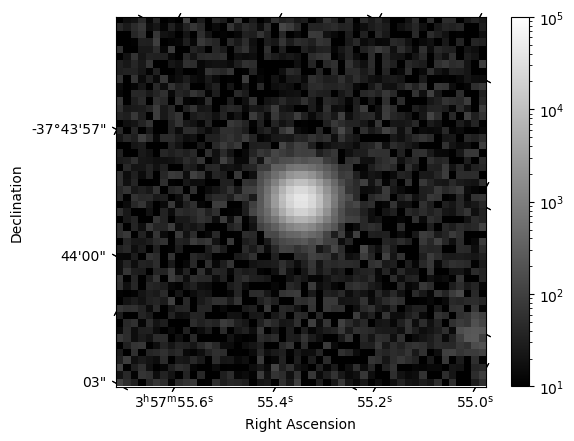

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.3814532411, -37.7756685068)
Pixel Origin: (1852.77, 2153.35)
Pixel Scale: 0.199689 arcsec/pixel
xy:  (1219, 658)
bbox:  (minimum=(1194, 633), maximum=(1243, 682))


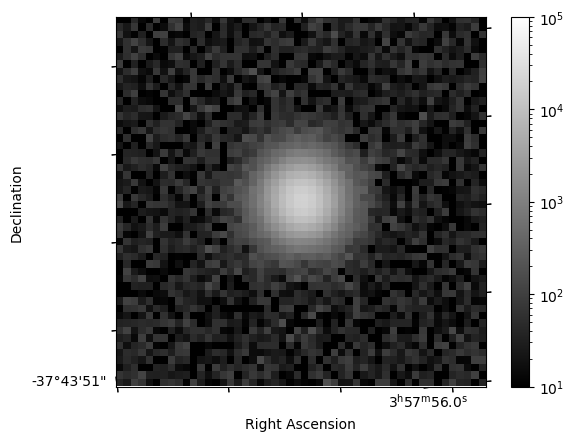

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.4596635784, -37.7125600724)
Pixel Origin: (1863.37, 2055.09)
Pixel Scale: 0.199887 arcsec/pixel
xy:  (2062, 1627)
bbox:  (minimum=(2037, 1602), maximum=(2086, 1651))


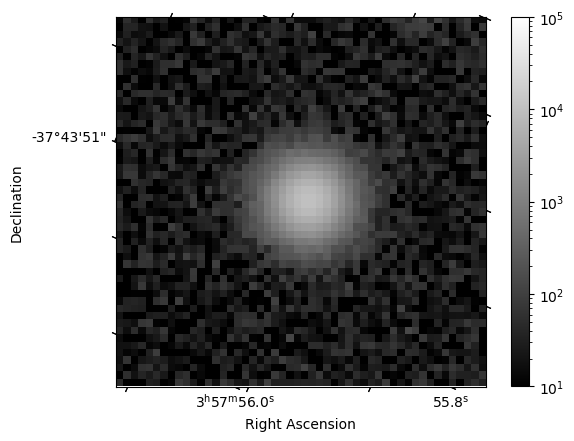

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.3999708583, -37.7178027853)
Pixel Origin: (2023.5, 2102.39)
Pixel Scale: 0.199781 arcsec/pixel
xy:  (2785, 1186)
bbox:  (minimum=(2760, 1161), maximum=(2809, 1210))


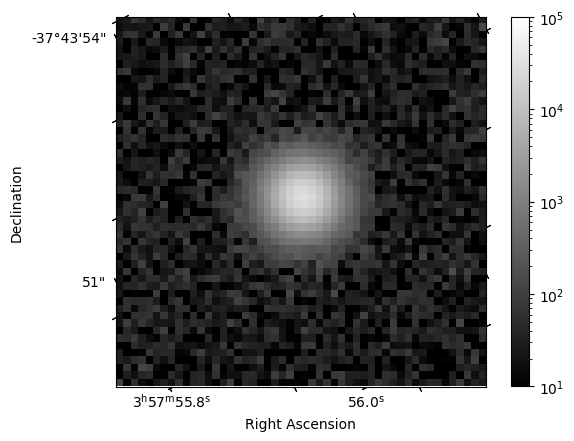

calexp wcs:  FITS standard SkyWcs:
Sky Origin: (59.4900575074, -37.6747776780)
Pixel Origin: (2071.07, 2110.74)
Pixel Scale: 0.199677 arcsec/pixel
xy:  (1964, 1071)
bbox:  (minimum=(1939, 1046), maximum=(1988, 1095))


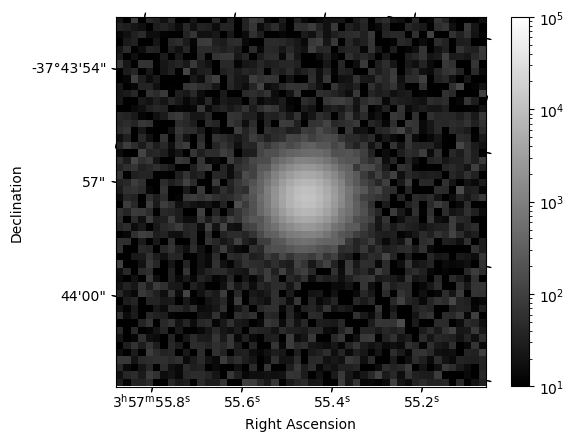

In [19]:
# main directory
batch_dir = './variable_stars_output/' 

'''
star_id = diaobjectID # in sree's OG example, this was the object ID not the diaObjID, so maybe change
star_ccdid = 662532066

calexp_image = get_cutout_image(butler, 59.4814837, -37.7323315, 662532, 66, 'g', 50, datasetType='calexp')
figout = make_calexp_fig(calexp_image, 59.4814837, -37.7323315, batch_dir+"/images/"+str(star_id)+"_"+str(star_ccdid)+".png")
''' 

# 
figout_data = {"sourceId": diaobjectID}
'''
if "coord_ra" in fields_to_add:
    figout_data["coord_ra"] = stars_ra[j]
if "coord_dec" in fields_to_add:
    figout_data["coord_dec"] = stars_dec[j]
'''
cutouts = []
    
for i, idx in enumerate(idx_select):
    star_ra = sorted_sources['ra'][idx]
    star_dec = sorted_sources['decl'][idx]
    star_detector = sorted_sources['detector'][idx]
    star_visitid = sorted_sources['visitId'][idx]
    star_id = sorted_sources['diaObjectId'][idx] # WAS objectId
    star_ccdid = sorted_sources['ccdVisitId'][idx]

    calexp_image = get_cutout_image(butler, star_ra, star_dec, star_visitid, star_detector, 'r', 50, datasetType='calexp') # only r-band images 
    figout = make_calexp_fig(calexp_image, star_ra,star_dec, batch_dir+"/images/"+str(star_id)+"_"+str(star_ccdid)+".png")
    plt.show()
    remove_figure(figout)
    
    
    
    figout_data['location:image_'+str(i)] = str(star_id)+"_"+str(star_ccdid)+".png"
    figout_data['filename'] = str(star_id)+"_"+str(star_ccdid)+".png"
        
#cutouts.append(figout_data)

# manifest file
df_manifest = pd.DataFrame(data = figout_data, index=[0])


    
#df_manifest = pd.concat(df_final) # final manifest file with all variable stars
outfile = batch_dir+"images/manifest.csv"
df_manifest.to_csv(outfile, index=False, sep=',')

    #figout_data['location:image_'+str(i)] = str(star_id)+"_"+str(star_ccdid)+".png"
    #figout_data['filename'] = str(star_id)+"_"+str(star_ccdid)+".png"

star 1567428592185376787


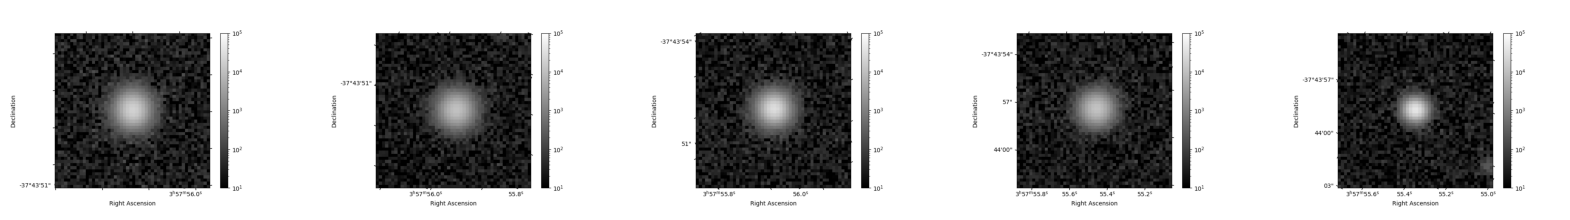

only one star


In [20]:

# go through your variable_stars_output/images
# and make a figure

image_dir = 'variable_stars_output/images/'
num_variable_images = 5
stars_matchid_list = [diaobjectID]

star_name = np.zeros((1, num_variable_images))
star_name = []
for i, id_star in enumerate(stars_matchid_list):
    # go through and sort by ccdID so that they are in order of time
    # DOUBLE CHECK THAT THIS IS TIME ORDER
    ccdID_list = []
    for j, file in enumerate(os.listdir(image_dir)):
        if str.split(file,'.')[1] == 'png' and str.split(file,'_')[0] == str(id_star):
            star_name.append(str(id_star)+'_'+str(int(str.split(str.split(file,'_')[1],'.')[0]))+'.png')

# Okay now go through and plot each of these
fig, axs = plt.subplots(1,5, figsize = (20,20))
print('star', stars_matchid_list[0])
for j in range(num_variable_images):
    image = mpimg.imread(image_dir + star_name[j])
    axs[j].imshow(image)#, norm = matplotlib.colors.LogNorm())
    axs[j].axis('off')
plt.show()

try:
    print('star', stars_matchid_list[1])
    fig, axs = plt.subplots(1,5, figsize = (20,20))

    for j in range(num_variable_images):
        image = mpimg.imread(image_dir + star_name[j+num_variable_images])
        axs[j].imshow(image)
        axs[j].axis('off')
    plt.show()

except IndexError: # which will happen if you have only one star
    print('only one star')


The third and fifth image should be the brightest.

## A word of caution
Note that the pixelscale is changing for these images ever so slightly. This is annoying me, we need a better explanation for how people might do better here (without actually doing it ourself). Something like, "you should really use coadded images here" but we don't because XXXXX.

## Send manifest to zooniverse

In [21]:
cutout_dir = batch_dir+"images/"
subject_set_name = "test_flipbook" 
cit_sci_pipeline.send_image_data(subject_set_name, cutout_dir)

'1. Checking batch status'

'2. Zipping up all the astro cutouts - this can take a few minutes with large data sets, but unlikely more than 10 minutes.'

'3. Uploading the citizen science data'

'4. Creating a new Zooniverse subject set'

'5. Notifying the Rubin EPO Data Center of the new data, which will finish processing of the data and notify Zooniverse'

'** Additional information:'

'6. Sending the manifest URL to Zooniverse'

'** Information: subject_set.id: 117172; manifest: https://storage.googleapis.com/citizen-science-data-public/ac9d49f9-f75a-4320-9d70-6ea60352b68b/manifest.csv'

'7. Transfer process complete, but further processing is required on the Zooniverse platform and you will receive an email at beckynevin@gmail.com'